<a href="https://colab.research.google.com/github/JonatanPolanco/ML_Projects/blob/main/MLzoomcamp_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

#**Data Preparation** ✅

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv'

In [3]:
!wget $data

--2021-12-02 23:56:53--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1475504 (1.4M) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>]   1.41M  --.-KB/s    in 0.04s   

2021-12-02 23:56:54 (37.9 MB/s) - ‘data.csv’ saved [1475504/1475504]



In [4]:
df = pd.read_csv(data)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [7]:
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings

['make',
 'model',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style']

In [8]:
for col in strings:
  df[col] = df[col].str.lower().str.replace(' ', '_')

In [9]:
df.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
0,bmw,1_series_m,2011,premium_unleaded_(required),335.0,6.0,manual,rear_wheel_drive,2.0,"factory_tuner,luxury,high-performance",compact,coupe,26,19,3916,46135
1,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,convertible,28,19,3916,40650
2,bmw,1_series,2011,premium_unleaded_(required),300.0,6.0,manual,rear_wheel_drive,2.0,"luxury,high-performance",compact,coupe,28,20,3916,36350
3,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,"luxury,performance",compact,coupe,28,18,3916,29450
4,bmw,1_series,2011,premium_unleaded_(required),230.0,6.0,manual,rear_wheel_drive,2.0,luxury,compact,convertible,28,18,3916,34500


#**Exploratory data analysis** ✅





In [10]:
for col in df.columns:
  print(col)
  print(df[col].unique()[:5])
  print(df[col].nunique())
  print()

make
['bmw' 'audi' 'fiat' 'mercedes-benz' 'chrysler']
48

model
['1_series_m' '1_series' '100' '124_spider' '190-class']
914

year
[2011 2012 2013 1992 1993]
28

engine_fuel_type
['premium_unleaded_(required)' 'regular_unleaded'
 'premium_unleaded_(recommended)' 'flex-fuel_(unleaded/e85)' 'diesel']
10

engine_hp
[335. 300. 230. 320. 172.]
356

engine_cylinders
[ 6.  4.  5.  8. 12.]
9

transmission_type
['manual' 'automatic' 'automated_manual' 'direct_drive' 'unknown']
5

driven_wheels
['rear_wheel_drive' 'front_wheel_drive' 'all_wheel_drive'
 'four_wheel_drive']
4

number_of_doors
[ 2.  4.  3. nan]
3

market_category
['factory_tuner,luxury,high-performance' 'luxury,performance'
 'luxury,high-performance' 'luxury' 'performance']
71

vehicle_size
['compact' 'midsize' 'large']
3

vehicle_style
['coupe' 'convertible' 'sedan' 'wagon' '4dr_hatchback']
16

highway_mpg
[26 28 27 25 24]
59

city_mpg
[19 20 18 17 16]
69

popularity
[3916 3105  819  617 1013]
48

msrp
[46135 40650 36350 29450 345

###Distribution of price

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

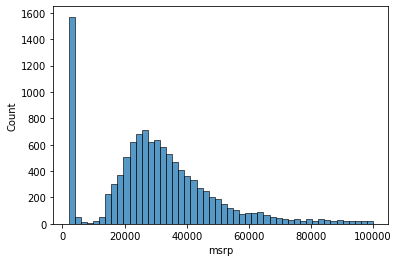

In [12]:
sns.histplot(df.msrp[df.msrp < 100000], bins=50)  #Long tail distribution (Not good for ML). So, we need to apply another distribution

In [13]:
#Logaritmic distribution
np.log1p([0 , 10, 1000, 100000]) #Log of 0 doesn´t exist so we use log1p which adds 1 to all values

array([ 0.        ,  2.39789527,  6.90875478, 11.51293546])

In [14]:
price_logs = np.log1p(df.msrp)

In [15]:
price_logs

0        10.739349
1        10.612779
2        10.500977
3        10.290483
4        10.448744
           ...    
11909    10.739024
11910    10.945018
11911    10.832122
11912    10.838031
11913    10.274913
Name: msrp, Length: 11914, dtype: float64

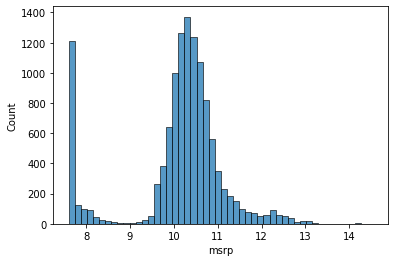

In [16]:
sns.histplot(price_logs, bins=50) #Looks like normal distribution (ideal to models)

###Missing values (nan)

In [17]:
df.isnull().sum()

make                    0
model                   0
year                    0
engine_fuel_type        3
engine_hp              69
engine_cylinders       30
transmission_type       0
driven_wheels           0
number_of_doors         6
market_category      3742
vehicle_size            0
vehicle_style           0
highway_mpg             0
city_mpg                0
popularity              0
msrp                    0
dtype: int64

#**Setting up the validation framework** ✅
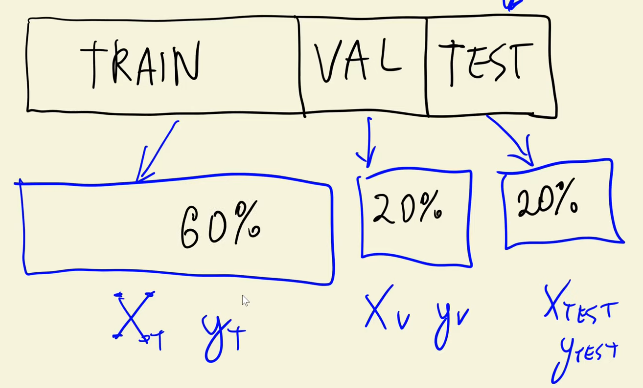

In [18]:
n = len(df)
n_val = int(len(df) * 0.2)
n_test = int(len(df) * 0.2)
n_train = n - n_val - n_test # 60% of df

In [19]:
n_train, n_val, n_test

(7150, 2382, 2382)

In [20]:
n, n_val + n_test + n_train

(11914, 11914)

In [21]:
#We need to shuffle the data to get diferent values in train, test and val df's
np.random.seed(2)
idx = np.arange(n)
np.random.shuffle(idx)

In [22]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train+n_val]]
df_test = df.iloc[idx[n_train+n_val:]]

In [23]:
df_train

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,msrp
2735,chevrolet,cobalt,2008,regular_unleaded,148.0,4.0,manual,front_wheel_drive,2.0,NaN,compact,coupe,33,24,1385,14410
6720,toyota,matrix,2012,regular_unleaded,132.0,4.0,automatic,front_wheel_drive,4.0,hatchback,compact,4dr_hatchback,32,25,2031,19685
5878,subaru,impreza,2016,regular_unleaded,148.0,4.0,automatic,all_wheel_drive,4.0,hatchback,compact,4dr_hatchback,37,28,640,19795
11190,volkswagen,vanagon,1991,regular_unleaded,90.0,4.0,manual,rear_wheel_drive,3.0,NaN,large,passenger_minivan,18,16,873,2000
4554,ford,f-150,2017,flex-fuel_(unleaded/e85),385.0,8.0,automatic,four_wheel_drive,4.0,flex_fuel,large,crew_cab_pickup,21,15,5657,56260
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,bmw,4_series,2015,premium_unleaded_(required),300.0,6.0,automatic,rear_wheel_drive,2.0,"luxury,performance",midsize,convertible,31,20,3916,54900
1902,volkswagen,beetle,2015,premium_unleaded_(recommended),210.0,4.0,automated_manual,front_wheel_drive,2.0,"hatchback,performance",compact,2dr_hatchback,30,24,873,29215
9334,gmc,sierra_1500,2015,flex-fuel_(unleaded/e85),285.0,6.0,automatic,four_wheel_drive,4.0,flex_fuel,large,extended_cab_pickup,22,17,549,34675
5284,rolls-royce,ghost,2014,premium_unleaded_(required),563.0,12.0,automatic,rear_wheel_drive,4.0,"exotic,luxury,performance",large,sedan,21,13,86,303300


In [24]:
len(df_train), len(df_val), len(df_test)

(7150, 2382, 2382)

In [25]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [26]:
y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

In [27]:
del df_train['msrp']
del df_val['msrp']
del df_test['msrp']

# **Linear regression**

Linear Regression modeling formula

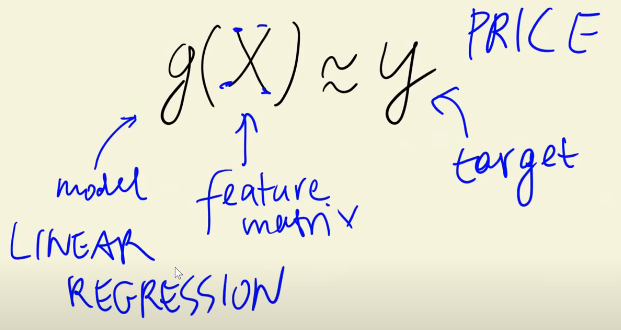

The feature matrix in previous formula contains the features of all cars. This is not that we want.

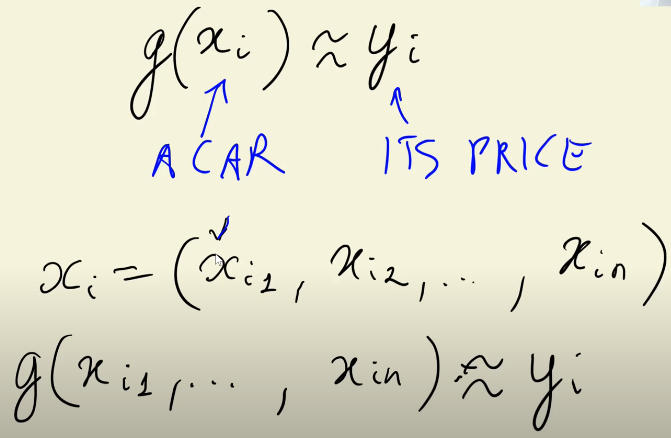

Let's create our Feature Matrix!

Example of feature matrix:

In [29]:
df_train.iloc[10]

make                                 rolls-royce
model                     phantom_drophead_coupe
year                                        2015
engine_fuel_type     premium_unleaded_(required)
engine_hp                                    453
engine_cylinders                              12
transmission_type                      automatic
driven_wheels                   rear_wheel_drive
number_of_doors                                2
market_category        exotic,luxury,performance
vehicle_size                               large
vehicle_style                        convertible
highway_mpg                                   19
city_mpg                                      11
popularity                                    86
Name: 10, dtype: object

In [30]:
xi = [453, 11, 86] # Feature matrix i=10 [engine_hp, city_mpg , popularity] for rolls-roycecar

[453, 11, 86]

In [ ]:
example of model (g)
def g(xi):
  #do someting
  return 10000

Linear Regression Formula

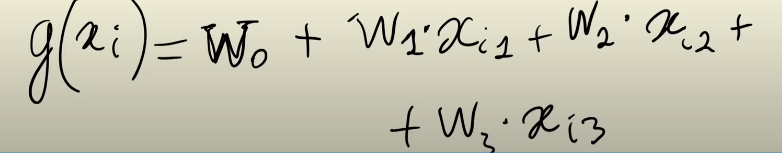

This formula can be summarized as follows

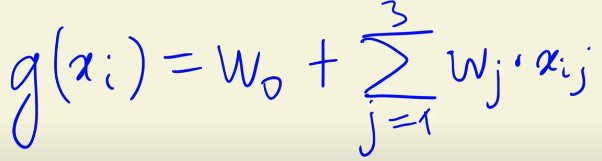

Where W0 is the bias term, wj is the weight of each feature and xi the feature

Let's implement this!

In [34]:
xi = [453, 11, 86]

In [38]:
w0 = 7.17
w = [0.01, 0.04, 0.002]

In [39]:
def linear_regression(xi):
  n = len(xi)

  pred = w0

  for j in range(n):
    pred = pred + w[j] * xi[j]

  return pred

In [40]:
linear_regression(xi)

12.312

In [41]:
np.expm1(linear_regression(xi))

222347.2221101062

In [42]:
np.log1p(np.expm1(linear_regression(xi)))

12.312